<a href="https://colab.research.google.com/github/kparnis3/Final-Year-Project/blob/main/Code/CnnTraining_Static.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.utils.data import Dataset
from torchsummary import summary

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
#train and test data directory
data_dir = "/content/gdrive/MyDrive/ThesisImages/oa2_train"
test_data_dir = "/content/gdrive/MyDrive/ThesisImages/oa2_test"

In [ ]:
#load the train and test data
dataset = ImageFolder(data_dir,transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
    transforms.Resize((150,150)),transforms.ToTensor()
]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([transforms.Grayscale(num_output_channels=1),
    transforms.Resize((150,150)),transforms.ToTensor()
]))

In [ ]:
print(f"Images in training data : {len(dataset)}")
print(f"Images in test data : {len(test_dataset)}")

Images in training data : 9354
Images in test data : 1040


In [ ]:
print("Classes: \n",dataset.classes)

Classes: 
 ['Collision', 'NonCollision']


In [ ]:
class_names = dataset.classes
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [ ]:
img, label = dataset[0]
print(img.shape,label)

torch.Size([1, 150, 150]) 0


In [ ]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0), cmap='gray')

Label : Collision


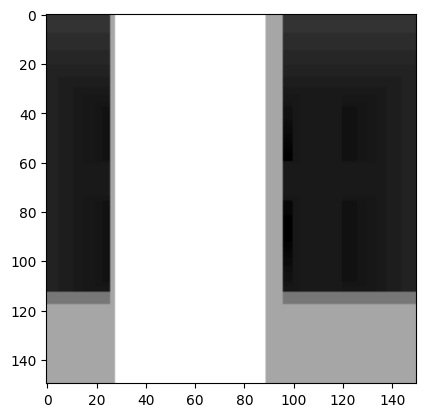

In [ ]:
display_img(*dataset[2])

In [ ]:
random_seed = 2021
torch.manual_seed(random_seed)

In [ ]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

val_percentage = 0.2
batch_size = 128
val_size = int(len(dataset)*val_percentage)
train_size = len(dataset) - val_size 

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

Length of Train Data : 7484
Length of Validation Data : 1870


In [ ]:
#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 2, pin_memory = True)

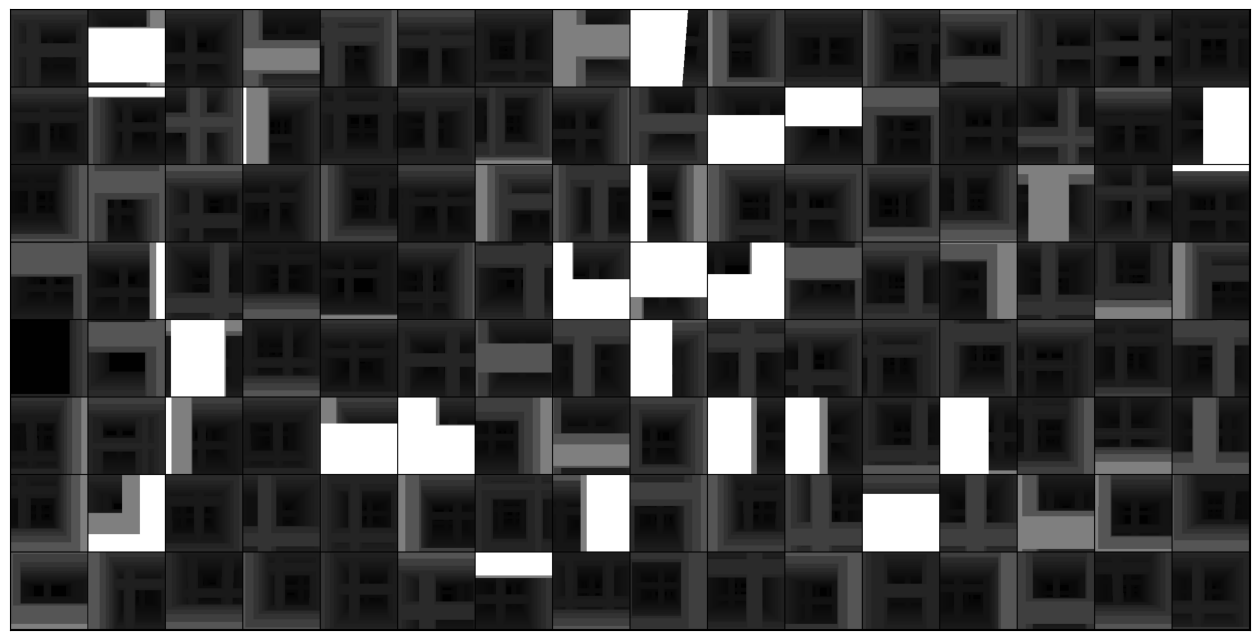

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
    def accuracy(outputs, labels):
      _, preds = torch.max(outputs, dim=1)
      return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ObjectDetection(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(256*18*18,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [ ]:
class ObjectDetection2(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Flatten(),
            nn.Linear(128*18*18, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, image):
        output = self.model(image)
        return output

In [ ]:
class ObjectDetection3(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(14400, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, image):
        output = self.model(image)
        return output

In [ ]:
model = ObjectDetection(num_classes=2)
model

ObjectDetection(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=82944, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_fea

In [ ]:
model2 = ObjectDetection2(num_classes=2)
model2

ObjectDetection2(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=41472, out_features=512, bias=True)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=64, bias=True)
    (13): ReLU()
    (14): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [ ]:
model3 = ObjectDetection3(num_classes=2)
model3

ObjectDetection3(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=14400, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 1, 150, 150])
out.shape: torch.Size([128, 2])
out[0]: tensor([ 0.0396, -0.0376], grad_fn=<SelectBackward0>)


In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model2(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 1, 150, 150])
out.shape: torch.Size([128, 2])
out[0]: tensor([-0.0088,  0.1133], grad_fn=<SelectBackward0>)


In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model3(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 1, 150, 150])
out.shape: torch.Size([128, 2])
out[0]: tensor([-0.0120,  0.0602], grad_fn=<SelectBackward0>)


In [ ]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """ Number of batches """
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
# load the into GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ObjectDetection(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=82944, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_fea

In [ ]:
# load the into GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model2, device)

ObjectDetection2(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=41472, out_features=512, bias=True)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=64, bias=True)
    (13): ReLU()
    (14): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [ ]:
# load the into GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model3, device)

ObjectDetection3(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=14400, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [ ]:
summary(model, (1,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 150, 150]             320
              ReLU-2         [-1, 32, 150, 150]               0
            Conv2d-3         [-1, 64, 150, 150]          18,496
              ReLU-4         [-1, 64, 150, 150]               0
         MaxPool2d-5           [-1, 64, 75, 75]               0
            Conv2d-6          [-1, 128, 75, 75]          73,856
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,584
              ReLU-9          [-1, 128, 75, 75]               0
        MaxPool2d-10          [-1, 128, 37, 37]               0
           Conv2d-11          [-1, 256, 37, 37]         295,168
             ReLU-12          [-1, 256, 37, 37]               0
           Conv2d-13          [-1, 256, 37, 37]         590,080
             ReLU-14          [-1, 256,

In [ ]:
summary(model2, (1,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 150, 150]             320
              ReLU-2         [-1, 32, 150, 150]               0
         MaxPool2d-3           [-1, 32, 75, 75]               0
            Conv2d-4           [-1, 64, 75, 75]          18,496
              ReLU-5           [-1, 64, 75, 75]               0
         MaxPool2d-6           [-1, 64, 37, 37]               0
            Conv2d-7          [-1, 128, 37, 37]          73,856
              ReLU-8          [-1, 128, 37, 37]               0
         MaxPool2d-9          [-1, 128, 18, 18]               0
          Flatten-10                [-1, 41472]               0
           Linear-11                  [-1, 512]      21,234,176
             ReLU-12                  [-1, 512]               0
           Linear-13                   [-1, 64]          32,832
             ReLU-14                   

In [ ]:
summary(model3, (1,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 36, 36]           2,080
              ReLU-2           [-1, 32, 36, 36]               0
            Conv2d-3           [-1, 64, 17, 17]          32,832
              ReLU-4           [-1, 64, 17, 17]               0
            Conv2d-5           [-1, 64, 15, 15]          36,928
              ReLU-6           [-1, 64, 15, 15]               0
           Flatten-7                [-1, 14400]               0
            Linear-8                  [-1, 256]       3,686,656
              ReLU-9                  [-1, 256]               0
           Linear-10                    [-1, 2]             514
Total params: 3,759,010
Trainable params: 3,759,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.09
Forward/backward pass size (MB): 1.25
Params size (MB): 14.34
Estima

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.Adam):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [ ]:
#load the model to the device
model = to_device(ObjectDetection(num_classes=2),device)

In [ ]:
#load the model to the device
model2 = to_device(ObjectDetection2(num_classes=2),device)

In [ ]:
#load the model to the device
model3 = to_device(ObjectDetection3(num_classes=2),device)

In [ ]:
#initial evaluation of the model
evaluate(model,val_dl)

{'val_loss': 0.6785131096839905, 'val_acc': 0.8588366508483887}

In [ ]:
#initial evaluation of the model
evaluate(model2,val_dl)

{'val_loss': 0.6866260766983032, 'val_acc': 0.8588366508483887}

In [ ]:
#initial evaluation of the model
evaluate(model3,val_dl)

{'val_loss': 0.7221444845199585, 'val_acc': 0.14116336405277252}

In [ ]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.1156, val_loss: 0.0521, val_acc: 0.9771
Epoch [1], train_loss: 0.0402, val_loss: 0.0391, val_acc: 0.9854
Epoch [2], train_loss: 0.0305, val_loss: 0.0395, val_acc: 0.9844
Epoch [3], train_loss: 0.0580, val_loss: 0.0472, val_acc: 0.9858
Epoch [4], train_loss: 0.0378, val_loss: 0.0343, val_acc: 0.9842
Epoch [5], train_loss: 0.0249, val_loss: 0.0307, val_acc: 0.9844
Epoch [6], train_loss: 0.0241, val_loss: 0.0423, val_acc: 0.9828
Epoch [7], train_loss: 0.0223, val_loss: 0.0268, val_acc: 0.9873
Epoch [8], train_loss: 0.0241, val_loss: 0.0449, val_acc: 0.9823
Epoch [9], train_loss: 0.0258, val_loss: 0.0432, val_acc: 0.9857
Epoch [10], train_loss: 0.0227, val_loss: 0.0267, val_acc: 0.9873
Epoch [11], train_loss: 0.0180, val_loss: 0.0201, val_acc: 0.9897
Epoch [12], train_loss: 0.0145, val_loss: 0.0296, val_acc: 0.9881
Epoch [13], train_loss: 0.0147, val_loss: 0.0213, val_acc: 0.9897
Epoch [14], train_loss: 0.0166, val_loss: 0.0208, val_acc: 0.9893
Epoch [15], train_lo

In [ ]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history2 = fit(num_epochs, lr, model2, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.1050, val_loss: 0.0413, val_acc: 0.9810
Epoch [1], train_loss: 0.0348, val_loss: 0.0482, val_acc: 0.9819
Epoch [2], train_loss: 0.0275, val_loss: 0.0325, val_acc: 0.9863
Epoch [3], train_loss: 0.0251, val_loss: 0.0324, val_acc: 0.9857
Epoch [4], train_loss: 0.0255, val_loss: 0.0481, val_acc: 0.9789
Epoch [5], train_loss: 0.0225, val_loss: 0.0276, val_acc: 0.9868
Epoch [6], train_loss: 0.0198, val_loss: 0.0311, val_acc: 0.9872
Epoch [7], train_loss: 0.0165, val_loss: 0.0249, val_acc: 0.9896
Epoch [8], train_loss: 0.0182, val_loss: 0.0268, val_acc: 0.9867
Epoch [9], train_loss: 0.0132, val_loss: 0.0264, val_acc: 0.9881
Epoch [10], train_loss: 0.0127, val_loss: 0.0312, val_acc: 0.9907
Epoch [11], train_loss: 0.0183, val_loss: 0.0294, val_acc: 0.9893
Epoch [12], train_loss: 0.0107, val_loss: 0.0406, val_acc: 0.9893
Epoch [13], train_loss: 0.0123, val_loss: 0.0439, val_acc: 0.9888
Epoch [14], train_loss: 0.0070, val_loss: 0.0366, val_acc: 0.9922
Epoch [15], train_lo

In [ ]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history3 = fit(num_epochs, lr, model3, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.0827, val_loss: 0.0436, val_acc: 0.9844
Epoch [1], train_loss: 0.0350, val_loss: 0.0379, val_acc: 0.9842
Epoch [2], train_loss: 0.0387, val_loss: 0.0357, val_acc: 0.9857
Epoch [3], train_loss: 0.0314, val_loss: 0.0353, val_acc: 0.9852
Epoch [4], train_loss: 0.0297, val_loss: 0.0366, val_acc: 0.9883
Epoch [5], train_loss: 0.0207, val_loss: 0.0515, val_acc: 0.9812
Epoch [6], train_loss: 0.0212, val_loss: 0.0358, val_acc: 0.9893
Epoch [7], train_loss: 0.0178, val_loss: 0.0342, val_acc: 0.9844
Epoch [8], train_loss: 0.0173, val_loss: 0.0309, val_acc: 0.9893
Epoch [9], train_loss: 0.0199, val_loss: 0.0354, val_acc: 0.9888
Epoch [10], train_loss: 0.0138, val_loss: 0.0447, val_acc: 0.9823
Epoch [11], train_loss: 0.0177, val_loss: 0.0540, val_acc: 0.9802
Epoch [12], train_loss: 0.0147, val_loss: 0.0451, val_acc: 0.9863
Epoch [13], train_loss: 0.0131, val_loss: 0.0367, val_acc: 0.9857
Epoch [14], train_loss: 0.0127, val_loss: 0.0400, val_acc: 0.9878
Epoch [15], train_lo

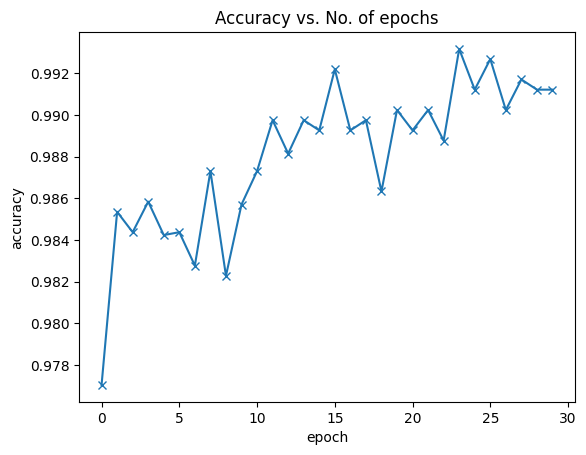

In [ ]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

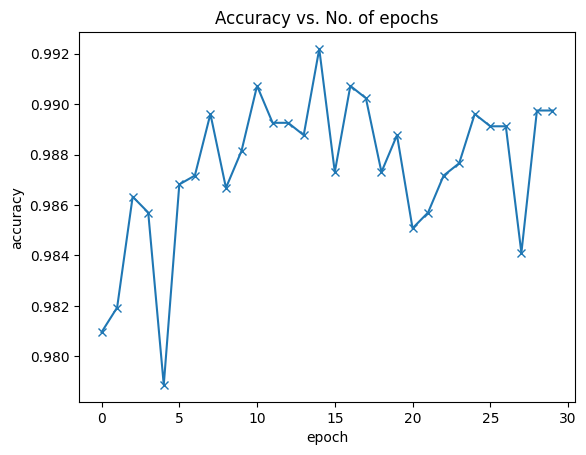

In [ ]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history2]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history2)

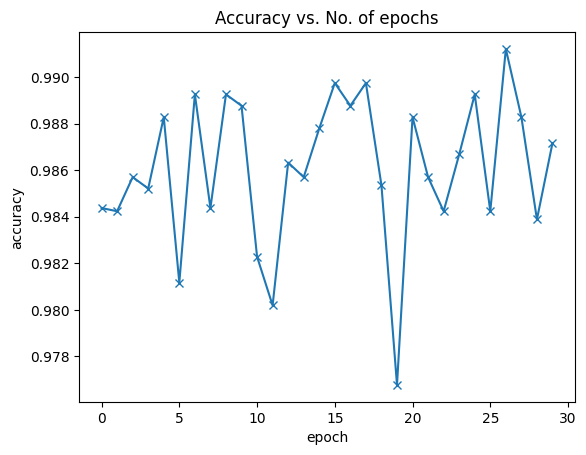

In [ ]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history3]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history3)

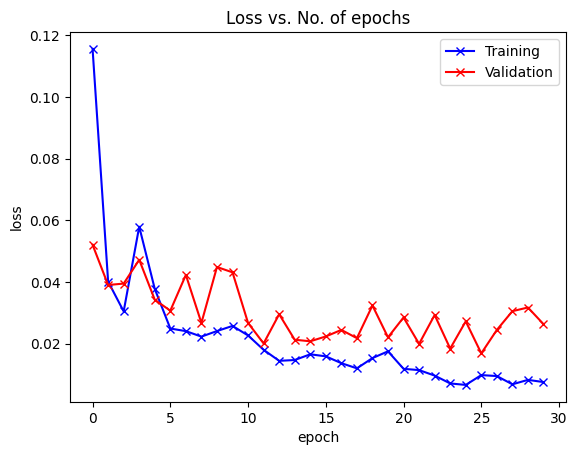

In [ ]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

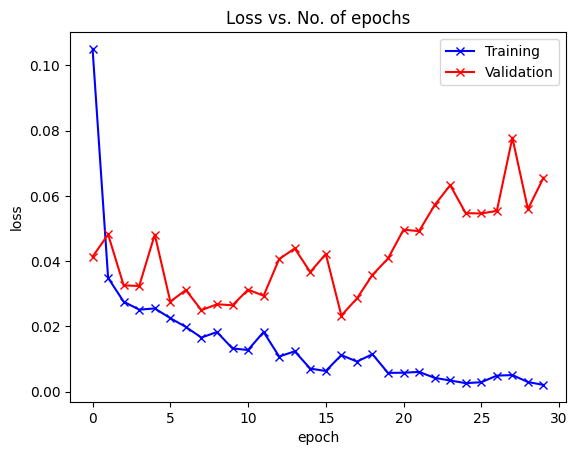

In [ ]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history2]
    val_losses = [x['val_loss'] for x in history2]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history2)

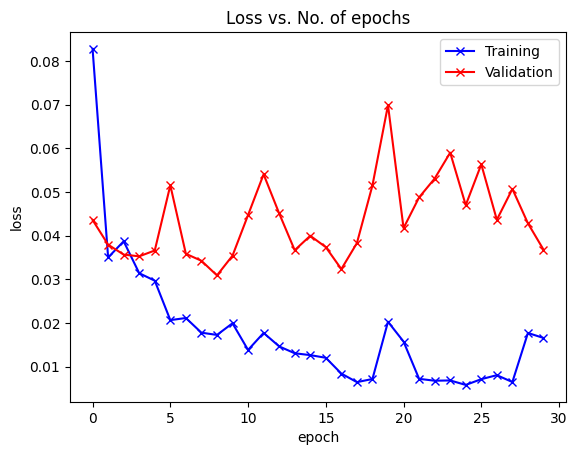

In [ ]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history3]
    val_losses = [x['val_loss'] for x in history3]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history3)

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model3, test_loader)
result

{'val_loss': 0.11791043728590012, 'val_acc': 0.9828125238418579}

In [ ]:
torch.save(model3.state_dict(), '/content/gdrive/MyDrive/ThesisImages/Models/collisiondetectionstatic3.pth')

In [ ]:
loadedmodel = ObjectDetection(num_classes=2)
loadedmodel.load_state_dict(torch.load('/content/gdrive/MyDrive/ThesisImages/Models/collisiondetectionstatic.pth'), strict=False)
loadedmodel.eval()

ObjectDetection(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=82944, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_fea

In [ ]:
def predict_img_class(img,model):
    """ Predict the class of image and Return Predicted Class"""
    img = to_device(img.unsqueeze(0), device)
    loadedmodel = to_device(model,device)
    prediction = loadedmodel(img)
    #probabilities = torch.nn.functional.softmax(prediction, dim=1).detach().cpu().numpy()
    #print(probabilities)
    print(prediction)
    _, preds = torch.max(prediction, dim = 1)
    return dataset.classes[preds[0].item()]

tensor([[ 5.8056, -4.1831]], device='cuda:0', grad_fn=<AddmmBackward0>)
Predicted Class : Collision


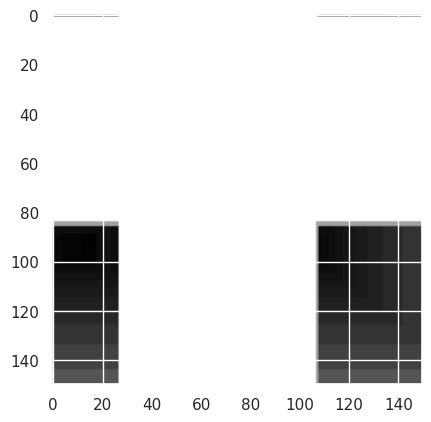

In [ ]:
from PIL import Image
import torchvision.transforms.functional as fn

#open image file
img = Image.open("/content/gdrive/MyDrive/ThesisImages/oa2_test/Collision/col0035.png")
sns.set(font_scale=1) # Adjust to fit
#convert image to tensor
img = fn.resize(img, size=[150,150])
img = transforms.ToTensor()(img)

#print image
plt.imshow(img.permute(1,2,0) , cmap='gray')

#prdict image label
print(f"Predicted Class : {predict_img_class(img,loadedmodel)}")

### Model One

In [ ]:
test_dl = DataLoader(test_dataset, batch_size=1, shuffle = False, num_workers = 1, pin_memory = True)
mylabel = [] 
mypred = []
with torch.no_grad():
    correct = 0
    for image, label in test_dl:
        image = image.to(device)  

        label = label.to(device)
        lab = label.detach().cpu().numpy()
        mylabel.append(lab[0])

        prediction = loadedmodel(image)
        _, preds = torch.max(prediction, dim = 1)
        pred = preds.detach().cpu().numpy()
        mypred.append(pred[0])

        correct += (preds == label).sum()

print(f'Test accuracy: {correct.item()}/{len(test_dataset)} = {correct.item()*100/(len(test_dataset )):7.3f}%')

Test accuracy: 1029/1040 =  98.942%


### Model Two

In [ ]:
test_dl = DataLoader(test_dataset, batch_size=1435, shuffle = False, num_workers = 2, pin_memory = True)

with torch.no_grad():
    correct = 0
    for image, label in test_dl:
        image = image.to(device)  
        label = label.to(device)
        prediction = loadedmodel(image)
        _, preds = torch.max(prediction, dim = 1)
        correct += (preds == label).sum()

print(f'Test accuracy: {correct.item()}/{len(test_dataset)} = {correct.item()*100/(len(test_dataset )):7.3f}%')

Test accuracy: 1029/1040 =  98.942%


### Model Three

In [ ]:
test_dl = DataLoader(test_dataset, batch_size=1435, shuffle = False, num_workers = 2, pin_memory = True)

with torch.no_grad():
    correct = 0
    for image, label in test_dl:
        image = image.to(device)  
        label = label.to(device)
        prediction = loadedmodel(image)
        _, preds = torch.max(prediction, dim = 1)
        correct += (preds == label).sum()

print(f'Test accuracy: {correct.item()}/{len(test_dataset)} = {correct.item()*100/(len(test_dataset )):7.3f}%')

Test accuracy: 1033/1040 =  99.327%


### Model One

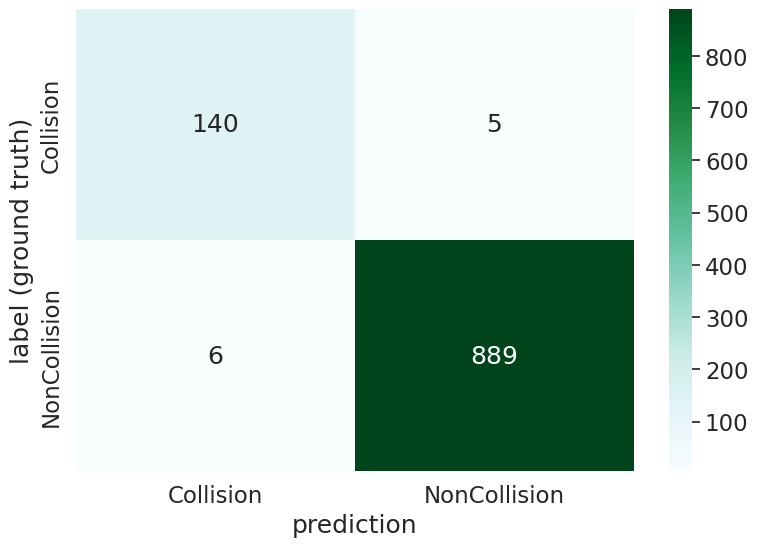

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

# Display the confusi on matrix as a heatmap
arr = confusion_matrix(mylabel, mypred)
sns.set(font_scale=1.5) # Adjust to fit
class_names = ['Collision', 'NonCollision']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print("\t\t\tClass report:\n",classification_report(preds.view(-1).detach().cpu().numpy(), label.view(-1).detach().cpu().numpy()))

			Class report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



### Model Two

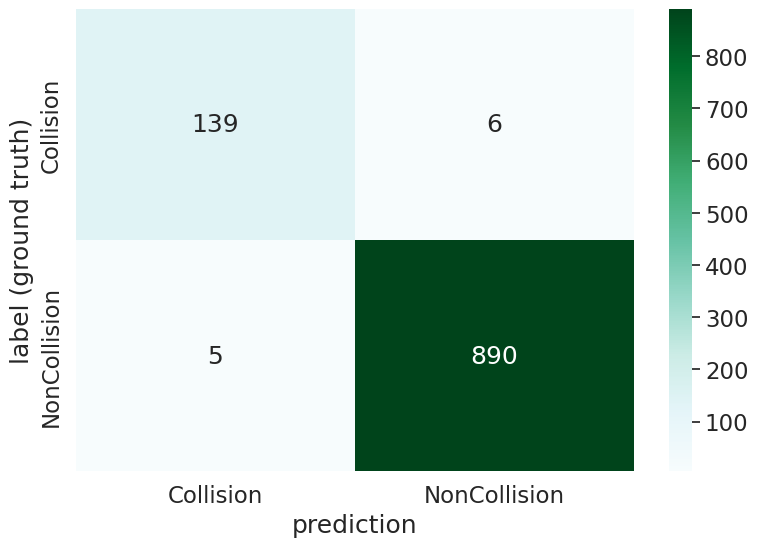

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

# Display the confusi on matrix as a heatmap
arr = confusion_matrix(label.view(-1).detach().cpu().numpy(), preds.view(-1).detach().cpu().numpy())
sns.set(font_scale=1.5) # Adjust to fit
class_names = ['Collision', 'NonCollision']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print("\t\t\tClass report:\n",classification_report(preds.view(-1).detach().cpu().numpy(), label.view(-1).detach().cpu().numpy()))

			Class report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       147
           1       1.00      1.00      1.00      1288

    accuracy                           1.00      1435
   macro avg       0.99      1.00      0.99      1435
weighted avg       1.00      1.00      1.00      1435



### Model Three

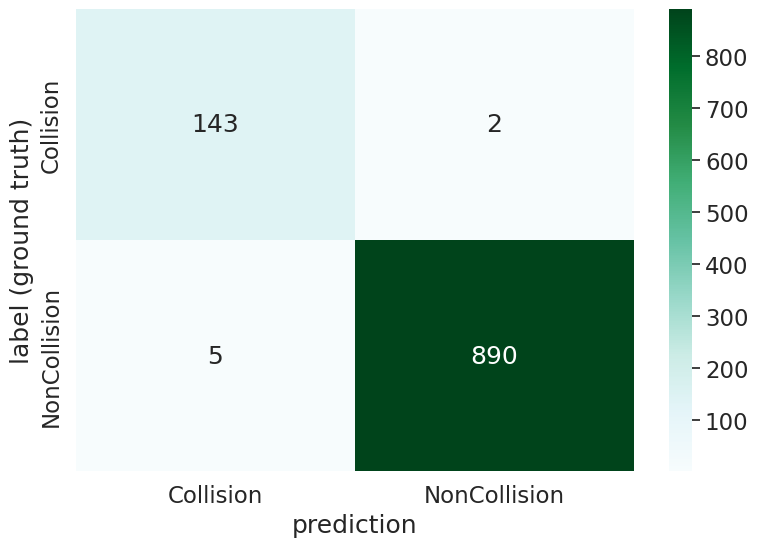

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

# Display the confusion matrix as a heatmap
arr = confusion_matrix(label.view(-1).detach().cpu().numpy(), preds.view(-1).detach().cpu().numpy())
sns.set(font_scale=1.5) # Adjust to fit
class_names = ['Collision', 'NonCollision']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print("\t\t\tClass report:\n",classification_report(preds.view(-1).detach().cpu().numpy(), label.view(-1).detach().cpu().numpy()))

			Class report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       148
           1       0.99      1.00      1.00       892

    accuracy                           0.99      1040
   macro avg       0.99      0.98      0.99      1040
weighted avg       0.99      0.99      0.99      1040

